In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [31]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [32]:
data_dir = "/kaggle/input/5-flower-types-classification-dataset/flower_images"

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
classes = full_dataset.classes
print(f"Detected Classes: {classes}")

Detected Classes: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


In [34]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [35]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training images: {len(train_dataset)}\nTest images: {len(test_dataset)}")

Training images: 3999
Test images: 1000


In [65]:
class FlowerCNN(nn.Module):
    def __init__(self):
        super(FlowerCNN, self).__init__()
        # 1st conv layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        # 2nd conv layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.dropo1 = nn.Dropout(p=0.4)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.dropo2 = nn.Dropout(p=0.2)
        self.relu5 = nn.ReLU()
        
        self.fc3 = nn.Linear(256, 5) 

    def forward(self, x):
        # 1st conv layer
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)


        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)


    
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.dropo1(x)
        x = self.relu4(x)

        x = self.fc2(x)
        x = self.dropo2(x)
        x = self.relu5(x)
        
        x = self.fc3(x)
        
        return x

In [66]:
model = FlowerCNN().to(device)

In [67]:

LR = 0.001
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [68]:
losses = []
for epoch in range(EPOCHS):
    model.train() 
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad() 
        loss.backward()       
        optimizer.step()    
        
        running_loss += loss.item()
    l = running_loss/len(train_loader)
    losses.append(l)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10 | Loss: 1.2603
Epoch 2/10 | Loss: 0.9359
Epoch 3/10 | Loss: 0.6397
Epoch 4/10 | Loss: 0.3289
Epoch 5/10 | Loss: 0.1444
Epoch 6/10 | Loss: 0.0978
Epoch 7/10 | Loss: 0.0907
Epoch 8/10 | Loss: 0.0497
Epoch 9/10 | Loss: 0.0379
Epoch 10/10 | Loss: 0.0732


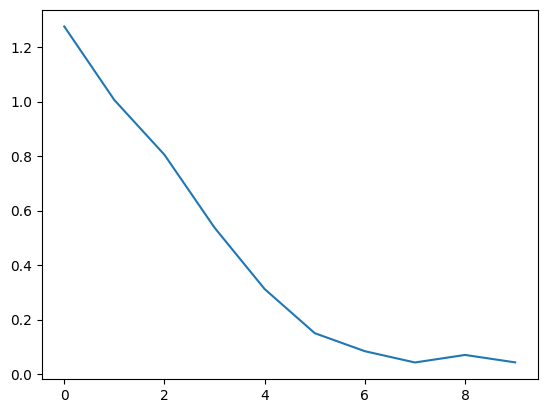

In [54]:
plt.plot(losses)

In [69]:
model.eval() 
correct = 0
total = 0

with torch.no_grad(): 
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Testing Accuracy: {accuracy:.2f}%")

Testing Accuracy: 99.72%


In [70]:
model.eval() 
correct = 0
total = 0

with torch.no_grad(): 
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Testing Accuracy: {accuracy:.2f}%")

Testing Accuracy: 85.40%


In [42]:
def get_all_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] 

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
         
            probs = F.softmax(outputs, dim=1)
            
            _, preds = torch.max(outputs, 1)
           
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

In [47]:
y_pred, y_true, y_probs = get_all_predictions(model, test_loader)

Text(0.5, 1.0, 'Confusion Matrix')

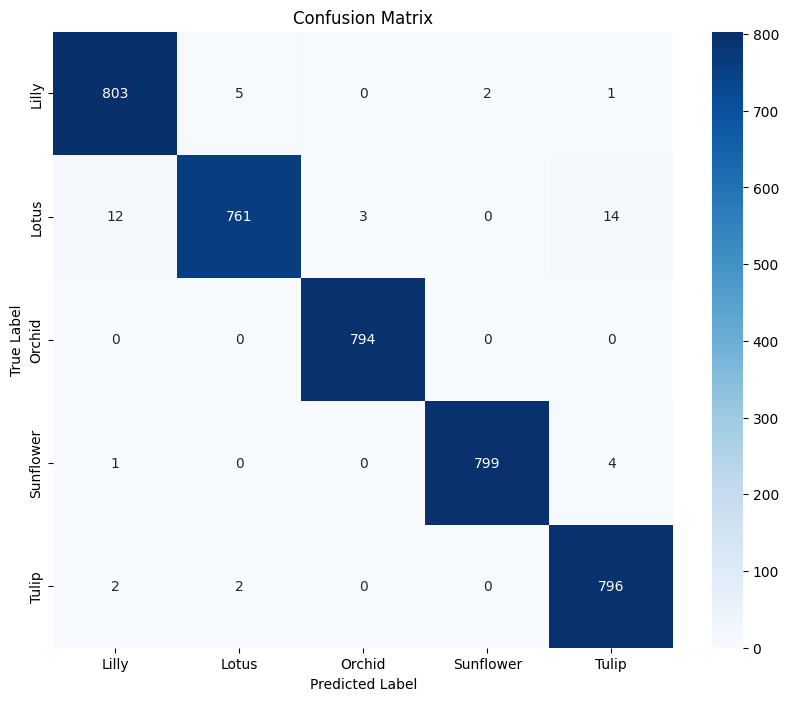

In [46]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


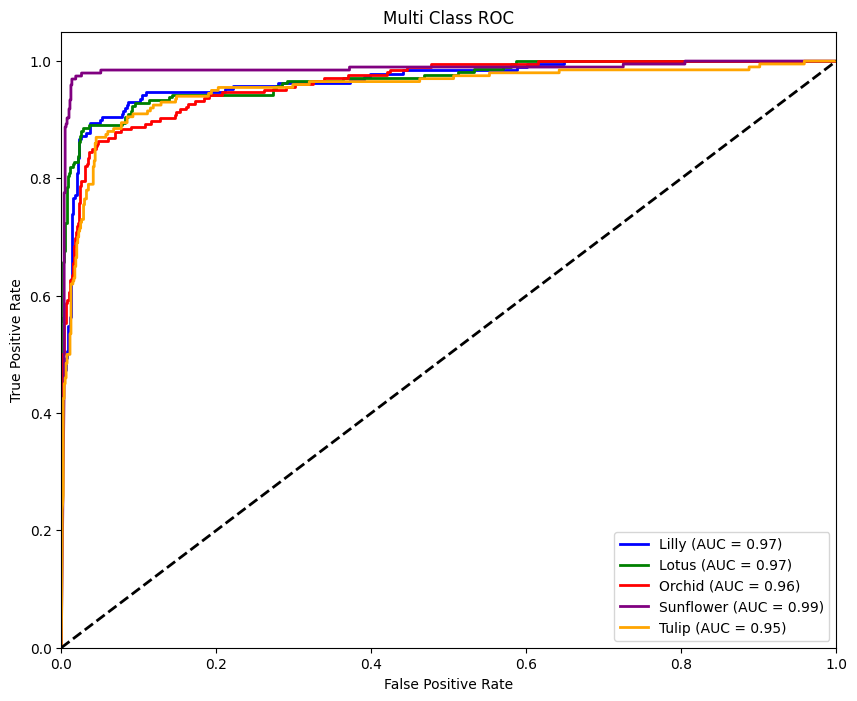

In [48]:
y_true_bin = label_binarize(y_true, classes=range(len(classes)))
n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC')
plt.legend(loc="lower right")
plt.show()

In [16]:
# def predict_image(image_path, model, classes):
#     from PIL import Image
    
#     image = Image.open(image_path)
 
#     image_tensor = transform(image).unsqueeze(0).to(device)
    
#     model.eval()
#     with torch.no_grad():
#         output = model(image_tensor)
#         _, predicted_idx = torch.max(output, 1)
#         predicted_class = classes[predicted_idx.item()]
        
#     return predicted_class


Final Prediction: Lotus


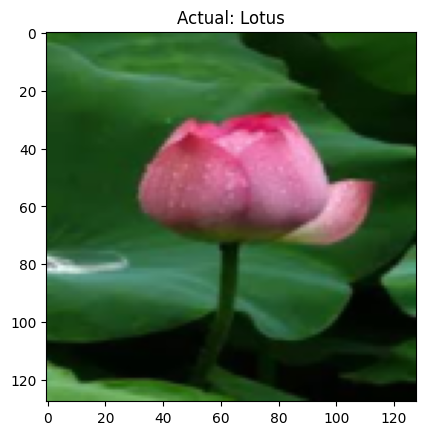

In [25]:
sample_img, sample_label = test_dataset[0] 

inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)
sample_img_inv = inv_normalize(sample_img)


plt.imshow(sample_img_inv.permute(1, 2, 0)) 
plt.title(f"Actual: {classes[sample_label]}")


sample_input = sample_img.unsqueeze(0).to(device)
with torch.no_grad():
    out = model(sample_input)
    _, pred = torch.max(out, 1)
    print(f"\nFinal Prediction: {classes[pred.item()]}")